The basic expiremental setup here is we have a stock dataset for the price of GOOG for 50 different samples. Each sample represents a sequence of 10 prices of GOOG in the stock market that are ordered timewise.
The columns in the dataset are [seq_id,	seq_time_id, seq_temporal_Close, seq_temporal_High,	seq_temporal_Low, seq_temporal_Open, seq_temporal_Volume, seq_out_Open_next]. All the columns represent temporal data except seq_id which is the id of the current sample and seq_out_Open_next which represents the open of the next day. I'm using all the columns to predict the close of the stock price in the 10th sample given. I'm using an LSTM layer with a dropout and then a linear layer to produce the close since this data isn't too complex. I trained the model with Adam and MSE loss.

In [1]:
import matplotlib.pyplot as plt

In [2]:
import sys
from os.path import dirname
sys.path.append(dirname('./synthcity/src/'))

In [3]:
import torch
import torch.nn as nn
import numpy as np

C:\Users\ma7mo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import torch.optim as optim
from torch.utils.data import DataLoader

In [6]:
import seaborn as sns

In [7]:
from synthcity.plugins import Plugins
from synthcity.benchmark import Benchmarks

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [8]:
Plugins(categories=["time_series"]).list()

['fflows', 'timegan', 'timevae']

In [9]:
from synthcity.utils.datasets.time_series.pbc import PBCDataloader
from synthcity.utils.datasets.time_series.google_stocks import GoogleStocksDataloader
from synthcity.plugins.core.dataloader import TimeSeriesDataLoader

In [10]:
static_data, temporal_data, horizons, outcome = GoogleStocksDataloader().load()

In [11]:
data = TimeSeriesDataLoader(
    temporal_data=temporal_data,
    observation_times=horizons,
    static_data=static_data,
    outcome=outcome,
)

In [12]:
data

,seq_id,seq_time_id,seq_temporal_Close,seq_temporal_High,seq_temporal_Low,seq_temporal_Open,seq_temporal_Volume,seq_out_Open_next
0,0,0.500000,0.297323,0.260691,0.270926,0.286676,0.537287,0.710852
1,0,0.488636,0.310959,0.261540,0.262191,0.247939,0.583420,0.710852
2,0,0.477273,0.379826,0.468139,0.383181,0.492445,1.000000,0.710852
3,0,0.443182,0.641220,0.837864,0.652282,0.767858,0.893648,0.710852
4,0,0.431818,0.751308,0.781931,0.737940,0.810440,0.810209,0.710852
...,...,...,...,...,...,...,...,...
495,49,0.170455,0.178331,0.096998,0.070274,0.000000,0.391364,0.246566
496,49,0.125000,0.000000,0.000000,0.000000,0.054121,0.436308,0.246566
497,49,0.113636,0.136612,0.044604,0.110952,0.062088,0.045596,0.246566
498,49,0.102273,0.164757,0.162135,0.166754,0.204533,0.195471,0.246566


In [13]:
train, test = train_test_split(data.dataframe(), test_size=0.2)

In [14]:
train

,seq_id,seq_time_id,seq_temporal_Close,seq_temporal_High,seq_temporal_Low,seq_temporal_Open,seq_temporal_Volume,seq_out_Open_next
161,16,0.977273,0.938730,0.932455,0.917341,0.944781,0.290232,0.387225
491,49,0.238636,0.433749,0.384961,0.422686,0.378984,0.249088,0.246566
218,21,0.829545,0.732379,0.732512,0.772230,0.756044,0.120629,0.286676
121,12,0.897727,0.791407,0.784055,0.800261,0.751374,0.140203,0.552061
271,27,0.636364,0.590535,0.540625,0.587745,0.510852,0.220572,0.597390
...,...,...,...,...,...,...,...,...
424,42,0.204545,0.427522,0.355707,0.284146,0.225962,0.382690,0.054121
287,28,0.090909,0.245703,0.213537,0.224863,0.163049,0.063596,0.390659
99,9,0.875000,0.696887,0.652789,0.677836,0.661264,0.185147,0.607281
247,24,0.727273,0.745205,0.717502,0.755411,0.684753,0.239609,0.767858


In [13]:
delta = 1/ (len(data) * np.log(len(data)))

In [14]:
syn_model_without_dp = Plugins().get("timegan", dp_enabled=False)

[2023-09-11T20:47:30.342577-0400][6672][CRITICAL] load failed: 
arfpy is not installed. Please install it with pip install arfpy.
Please be aware that arfpy is only available for python >= 3.8.

[2023-09-11T20:47:30.343581-0400][6672][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-11T20:47:30.343581-0400][6672][CRITICAL] module plugin_arf load failed
[2023-09-11T20:47:31.807930-0400][6672][CRITICAL] module disabled: C:\Users\ma7mo\Desktop\synthetic_time_series\src\./synthcity/src\synthcity\plugins\generic\plugin_goggle.py
[2023-09-11T20:47:31.809930-0400][6672][CRITICAL] load failed: 
GReaT is not installed. Please install it with pip install GReaT.
Please be aware that GReaT is only available for python >= 3.9.

[2023-09-11T20:47:31.810930-0400][6672][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-09-11T20:47:31.810930-0400][6672][CRITICAL] module plugin_great load failed


In [15]:
syn_model_with_dp_eps1 = Plugins().get("timegan", mode="DPRNN", dp_enabled=True, n_iter=300, epsilon=1., delta = delta)

[2023-09-11T20:47:33.109944-0400][6672][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-11T20:47:33.109944-0400][6672][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-11T20:47:33.111939-0400][6672][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-11T20:47:33.111939-0400][6672][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-11T20:47:33.113172-0400][6672][CRITICAL] module plugin_arf load failed
[2023-09-11T20:47:33.113172-0400][6672][CRITICAL] module plugin_arf load failed
[2023-09-11T20:47:33.113940-0400][6672][CRITICAL] module disabled: C:\Users\ma7mo\Desktop\synthetic_time_series\src\./synthcity/src\synthcity\plugins\generic\plugin_goggle.py
[2023-09-11T20:47:33.113940-0400][6672][CRITICAL] module disabled: C:\Users\ma7mo\Desktop\synthetic_time_series\src\./synthci

In [16]:
syn_model_with_dp_eps5 = Plugins().get("timegan", mode="DPRNN", dp_enabled=True, n_iter=300, epsilon=5., delta = delta)

[2023-09-11T20:47:33.141117-0400][6672][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-11T20:47:33.141117-0400][6672][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-11T20:47:33.141117-0400][6672][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-11T20:47:33.141117-0400][6672][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-11T20:47:33.142307-0400][6672][CRITICAL] module plugin_arf load failed
[2023-09-11T20:47:33.142307-0400][6672][CRITICAL] module plugin_arf load failed
[2023-09-11T20:47:33.143310-0400][6672][CRITICAL] module disabled: C:\Users\ma7mo\Desktop\synthetic_time_series\src\./synthcity/src\synthcity\plugins\generic\plugin_goggle.py
[2023-09-11T20:47:33.143310-0400][6672][CRITICAL] module disabled: C:\Users\ma7mo\Desktop\synthetic_time_series\src\./synthci

In [17]:
syn_model_with_dp_eps20 = Plugins().get("timegan", mode="DPRNN", dp_enabled=True, n_iter=300, epsilon=20., delta = delta)

[2023-09-11T20:47:33.171024-0400][6672][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-11T20:47:33.171024-0400][6672][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-11T20:47:33.171024-0400][6672][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-11T20:47:33.171024-0400][6672][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-11T20:47:33.172206-0400][6672][CRITICAL] module plugin_arf load failed
[2023-09-11T20:47:33.172206-0400][6672][CRITICAL] module plugin_arf load failed
[2023-09-11T20:47:33.173209-0400][6672][CRITICAL] module disabled: C:\Users\ma7mo\Desktop\synthetic_time_series\src\./synthcity/src\synthcity\plugins\generic\plugin_goggle.py
[2023-09-11T20:47:33.173209-0400][6672][CRITICAL] module disabled: C:\Users\ma7mo\Desktop\synthetic_time_series\src\./synthci

In [18]:
syn_model_without_dp.fit(data)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:11<00:00,  1.81it/s]


In [19]:
syn_model_with_dp_eps1.fit(data)

Enabling DP Privacy Engine: epsilon= 1.0 delta= 0.00032182238498800495 max_grad_norm= 2.0 secure_mode= False


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [34:02<00:00,  6.81s/it]


In [20]:
syn_model_with_dp_eps5.fit(data)

Enabling DP Privacy Engine: epsilon= 5.0 delta= 0.00032182238498800495 max_grad_norm= 2.0 secure_mode= False


100%|█████████████████████████████████████████████████████████████████████████████| 300/300 [1:35:12<00:00, 19.04s/it]


In [21]:
syn_model_with_dp_eps20.fit(data)

Enabling DP Privacy Engine: epsilon= 20.0 delta= 0.00032182238498800495 max_grad_norm= 2.0 secure_mode= False


100%|█████████████████████████████████████████████████████████████████████████████| 300/300 [8:12:00<00:00, 98.40s/it]


In [22]:
synth_data_without_dp = syn_model_without_dp.generate(count=len(data)/10)

In [23]:
synth_data_with_dp = syn_model_with_dp_eps1.generate(count=len(data)/10)

In [24]:
synth_data_with_dp_eps5 = syn_model_with_dp_eps5.generate(count=len(data)/10)

In [25]:
synth_data_with_dp_eps20 = syn_model_with_dp_eps20.generate(count=len(data)/10)

In [26]:
def create_sequence(dataset, seq_len):
    sequences = []
    labels = []


    for index in range(0, len(dataset)//seq_len): # Selecting 50 rows at a time
        sequences.append(dataset.iloc[index*seq_len:(index+1)*seq_len-1])
        labels.append(dataset.iloc[(index+1)*seq_len-1][2])
    return (np.array(sequences),np.array(labels))

In [27]:
def create_sequence_np(dataset, seq_len):
    sequences = []
    labels = []
    for index in range(0, len(dataset)): # Selecting 50 rows at a time
        sequences.append(dataset[index][:-1])
        labels.append(dataset[index][-1][2])
    return (np.array(sequences),np.array(labels))

In [28]:
class Network(nn.Module):
    def __init__(self, dropout,
                 input_dim=8, num_classes = 1, hidden_size = 10, **kwargs):

        super(Network, self).__init__()

        print("==> not used params in network class:", kwargs.keys())

        self.input_dim = input_dim
        self.dropout = dropout
        self.hidden_size = hidden_size


        # Main part of the network
        self.lstm_layers = nn.ModuleList()
        self.lstm_layers.append(nn.LSTM(input_size=input_dim,hidden_size=self.hidden_size))
        self.lstm_layers.append(nn.Dropout(p=dropout))
        # self.lstm_layers.append(nn.LSTM(input_size=self.hidden_size,
        #                    hidden_size=self.hidden_size))
        # self.lstm_layers.append(nn.Dropout(p=dropout))
        # self.lstm_layers.append(nn.LSTM(input_size=self.hidden_size,
        #                    hidden_size=self.hidden_size))
        # self.lstm_layers.append(nn.Dropout(p=dropout))
        # Output layer
        self.output_layer = nn.Linear(self.hidden_size, num_classes)
        # self.output_activation = nn.Sigmoid()

    def forward(self, X, lengths=None):
        # Input layer
        X = X.to(torch.float32)
        mX = X
        # Main part of the network
        i = 0
        for lstm in self.lstm_layers:
            if i % 2 == 0:
                output, _ = lstm(mX)
            else:
                output = lstm(mX)
            mX = output
            i += 1
        L = output[:, -1, :]
        # Output layer
        y = self.output_layer(L)
        return y


In [29]:
def run_model(model, training_error, testing_error, X_train, y_train, X_test, y_test):
    loss = nn.MSELoss()
    train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=1)
    val_loader = DataLoader(list(zip(X_test, y_test)), batch_size=1, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    for epoch in range(0, 100):
        model.train()
        step_loss = []
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            inputs, targets = batch
            outputs = model(inputs)
            targets = targets.reshape(tuple(outputs.shape))
            targets = targets.to(torch.float32)
            batch_loss = loss(outputs, targets)
            batch_loss.backward()
            optimizer.step()
            step_loss.append(batch_loss.item())
        training_error.append(np.array(step_loss).mean())
        model.eval()
        val_loss = 0
        with torch.no_grad():
            num_batches = 0
            res = {}
            y_true = []
            predictions = []
            for batch in val_loader:
                inputs, targets = batch
                outputs = model(inputs)
                targets = targets.reshape(tuple(outputs.shape))
                targets = targets.to(torch.float32)
                batch_loss = loss(outputs, targets)
                val_loss += batch_loss.item()
                num_batches += 1
            val_loss /= num_batches
            print('Epoch [{}/{}], Step [{}/{}], Validation Batch Loss: {:.4f}'
                    .format(epoch + 1, 100, i + 1, len(train_loader), val_loss))
        testing_error.append(val_loss)

In [30]:
random_data = np.random.rand(40, 10, 8)

In [31]:
X, y = create_sequence(data.dataframe(), 10)

In [32]:
synth_no_dp_X, synth_no_dp_y = create_sequence(synth_data_without_dp.dataframe(), 10)

In [33]:
synth_dp_X, synth_dp_y = create_sequence(synth_data_with_dp.dataframe(), 10)

In [34]:
synth_dp_eps5_X, synth_dp_eps5_y = create_sequence(synth_data_with_dp_eps5.dataframe(), 10)

In [35]:
synth_dp_eps20_X, synth_dp_eps20_y = create_sequence(synth_data_with_dp_eps20.dataframe(), 10)

In [36]:
random_X, random_y = create_sequence_np(random_data, 10)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [38]:
model = Network(0.2)
trainingEpoch_loss = []
validationEpoch_loss = []
run_model(model, trainingEpoch_loss, validationEpoch_loss, X_train, y_train, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [33/33], Validation Batch Loss: 0.1744
Epoch [2/100], Step [33/33], Validation Batch Loss: 0.0618
Epoch [3/100], Step [33/33], Validation Batch Loss: 0.0368
Epoch [4/100], Step [33/33], Validation Batch Loss: 0.0320
Epoch [5/100], Step [33/33], Validation Batch Loss: 0.0306
Epoch [6/100], Step [33/33], Validation Batch Loss: 0.0295
Epoch [7/100], Step [33/33], Validation Batch Loss: 0.0282
Epoch [8/100], Step [33/33], Validation Batch Loss: 0.0267
Epoch [9/100], Step [33/33], Validation Batch Loss: 0.0252
Epoch [10/100], Step [33/33], Validation Batch Loss: 0.0243
Epoch [11/100], Step [33/33], Validation Batch Loss: 0.0235
Epoch [12/100], Step [33/33], Validation Batch Loss: 0.0229
Epoch [13/100], Step [33/33], Validation Batch Loss: 0.0233
Epoch [14/100], Step [33/33], Validation Batch Loss: 0.0228
Epoch [15/100], Step [33/33], Validation Batch Loss: 0.0210
Epoch [16/100], Step [33/33], Validation Batch Loss: 0.01

In [39]:
synth_no_dp_model = Network(0.2)
trainingEpoch_no_dp_loss = []
validationEpoch_no_dp_loss = []
run_model(synth_no_dp_model, trainingEpoch_no_dp_loss, validationEpoch_no_dp_loss, synth_no_dp_X, synth_no_dp_y, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [50/50], Validation Batch Loss: 0.3832
Epoch [2/100], Step [50/50], Validation Batch Loss: 0.1641
Epoch [3/100], Step [50/50], Validation Batch Loss: 0.0739
Epoch [4/100], Step [50/50], Validation Batch Loss: 0.0662
Epoch [5/100], Step [50/50], Validation Batch Loss: 0.0597
Epoch [6/100], Step [50/50], Validation Batch Loss: 0.0531
Epoch [7/100], Step [50/50], Validation Batch Loss: 0.0506
Epoch [8/100], Step [50/50], Validation Batch Loss: 0.0503
Epoch [9/100], Step [50/50], Validation Batch Loss: 0.0555
Epoch [10/100], Step [50/50], Validation Batch Loss: 0.0502
Epoch [11/100], Step [50/50], Validation Batch Loss: 0.0472
Epoch [12/100], Step [50/50], Validation Batch Loss: 0.0504
Epoch [13/100], Step [50/50], Validation Batch Loss: 0.0491
Epoch [14/100], Step [50/50], Validation Batch Loss: 0.0461
Epoch [15/100], Step [50/50], Validation Batch Loss: 0.0482
Epoch [16/100], Step [50/50], Validation Batch Loss: 0.05

In [40]:
synth_dp_model = Network(0.2)
trainingEpoch_dp_loss = []
validationEpoch_dp_loss = []
run_model(synth_dp_model, trainingEpoch_dp_loss, validationEpoch_dp_loss, synth_dp_X, synth_dp_y, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [49/49], Validation Batch Loss: 0.2204
Epoch [2/100], Step [49/49], Validation Batch Loss: 0.0858
Epoch [3/100], Step [49/49], Validation Batch Loss: 0.0576
Epoch [4/100], Step [49/49], Validation Batch Loss: 0.0573
Epoch [5/100], Step [49/49], Validation Batch Loss: 0.0592
Epoch [6/100], Step [49/49], Validation Batch Loss: 0.0530
Epoch [7/100], Step [49/49], Validation Batch Loss: 0.0677
Epoch [8/100], Step [49/49], Validation Batch Loss: 0.0572
Epoch [9/100], Step [49/49], Validation Batch Loss: 0.0526
Epoch [10/100], Step [49/49], Validation Batch Loss: 0.0495
Epoch [11/100], Step [49/49], Validation Batch Loss: 0.0510
Epoch [12/100], Step [49/49], Validation Batch Loss: 0.0485
Epoch [13/100], Step [49/49], Validation Batch Loss: 0.0486
Epoch [14/100], Step [49/49], Validation Batch Loss: 0.0481
Epoch [15/100], Step [49/49], Validation Batch Loss: 0.0460
Epoch [16/100], Step [49/49], Validation Batch Loss: 0.04

In [41]:
synth_dp_eps5_model = Network(0.2)
trainingEpoch_dp_eps5_loss = []
validationEpoch_dp_eps5_loss = []
run_model(synth_dp_eps5_model, trainingEpoch_dp_eps5_loss, validationEpoch_dp_eps5_loss, synth_dp_eps5_X, synth_dp_eps5_y, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [50/50], Validation Batch Loss: 0.1437
Epoch [2/100], Step [50/50], Validation Batch Loss: 0.0542
Epoch [3/100], Step [50/50], Validation Batch Loss: 0.0339
Epoch [4/100], Step [50/50], Validation Batch Loss: 0.0339
Epoch [5/100], Step [50/50], Validation Batch Loss: 0.0356
Epoch [6/100], Step [50/50], Validation Batch Loss: 0.0362
Epoch [7/100], Step [50/50], Validation Batch Loss: 0.0403
Epoch [8/100], Step [50/50], Validation Batch Loss: 0.0384
Epoch [9/100], Step [50/50], Validation Batch Loss: 0.0369
Epoch [10/100], Step [50/50], Validation Batch Loss: 0.0362
Epoch [11/100], Step [50/50], Validation Batch Loss: 0.0367
Epoch [12/100], Step [50/50], Validation Batch Loss: 0.0382
Epoch [13/100], Step [50/50], Validation Batch Loss: 0.0370
Epoch [14/100], Step [50/50], Validation Batch Loss: 0.0364
Epoch [15/100], Step [50/50], Validation Batch Loss: 0.0389
Epoch [16/100], Step [50/50], Validation Batch Loss: 0.03

In [42]:
synth_dp_eps20_model = Network(0.2)
trainingEpoch_dp_eps20_loss = []
validationEpoch_dp_eps20_loss = []
run_model(synth_dp_eps20_model, trainingEpoch_dp_eps20_loss, validationEpoch_dp_eps20_loss, synth_dp_eps20_X, synth_dp_eps20_y, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [50/50], Validation Batch Loss: 0.0704
Epoch [2/100], Step [50/50], Validation Batch Loss: 0.0444
Epoch [3/100], Step [50/50], Validation Batch Loss: 0.0469
Epoch [4/100], Step [50/50], Validation Batch Loss: 0.0469
Epoch [5/100], Step [50/50], Validation Batch Loss: 0.0465
Epoch [6/100], Step [50/50], Validation Batch Loss: 0.0474
Epoch [7/100], Step [50/50], Validation Batch Loss: 0.0469
Epoch [8/100], Step [50/50], Validation Batch Loss: 0.0457
Epoch [9/100], Step [50/50], Validation Batch Loss: 0.0459
Epoch [10/100], Step [50/50], Validation Batch Loss: 0.0466
Epoch [11/100], Step [50/50], Validation Batch Loss: 0.0463
Epoch [12/100], Step [50/50], Validation Batch Loss: 0.0459
Epoch [13/100], Step [50/50], Validation Batch Loss: 0.0448
Epoch [14/100], Step [50/50], Validation Batch Loss: 0.0444
Epoch [15/100], Step [50/50], Validation Batch Loss: 0.0454
Epoch [16/100], Step [50/50], Validation Batch Loss: 0.04

In [43]:
random_model = Network(0.2)
trainingEpoch_random_loss = []
validationEpoch_random_loss = []
run_model(random_model, trainingEpoch_random_loss, validationEpoch_random_loss, random_X, random_y, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [40/40], Validation Batch Loss: 0.9048
Epoch [2/100], Step [40/40], Validation Batch Loss: 0.9101
Epoch [3/100], Step [40/40], Validation Batch Loss: 0.8458
Epoch [4/100], Step [40/40], Validation Batch Loss: 0.7385
Epoch [5/100], Step [40/40], Validation Batch Loss: 0.6505
Epoch [6/100], Step [40/40], Validation Batch Loss: 0.6089
Epoch [7/100], Step [40/40], Validation Batch Loss: 0.5711
Epoch [8/100], Step [40/40], Validation Batch Loss: 0.5624
Epoch [9/100], Step [40/40], Validation Batch Loss: 0.5630
Epoch [10/100], Step [40/40], Validation Batch Loss: 0.5611
Epoch [11/100], Step [40/40], Validation Batch Loss: 0.5534
Epoch [12/100], Step [40/40], Validation Batch Loss: 0.5496
Epoch [13/100], Step [40/40], Validation Batch Loss: 0.5349
Epoch [14/100], Step [40/40], Validation Batch Loss: 0.5283
Epoch [15/100], Step [40/40], Validation Batch Loss: 0.5330
Epoch [16/100], Step [40/40], Validation Batch Loss: 0.52

<function matplotlib.pyplot.show(close=None, block=None)>

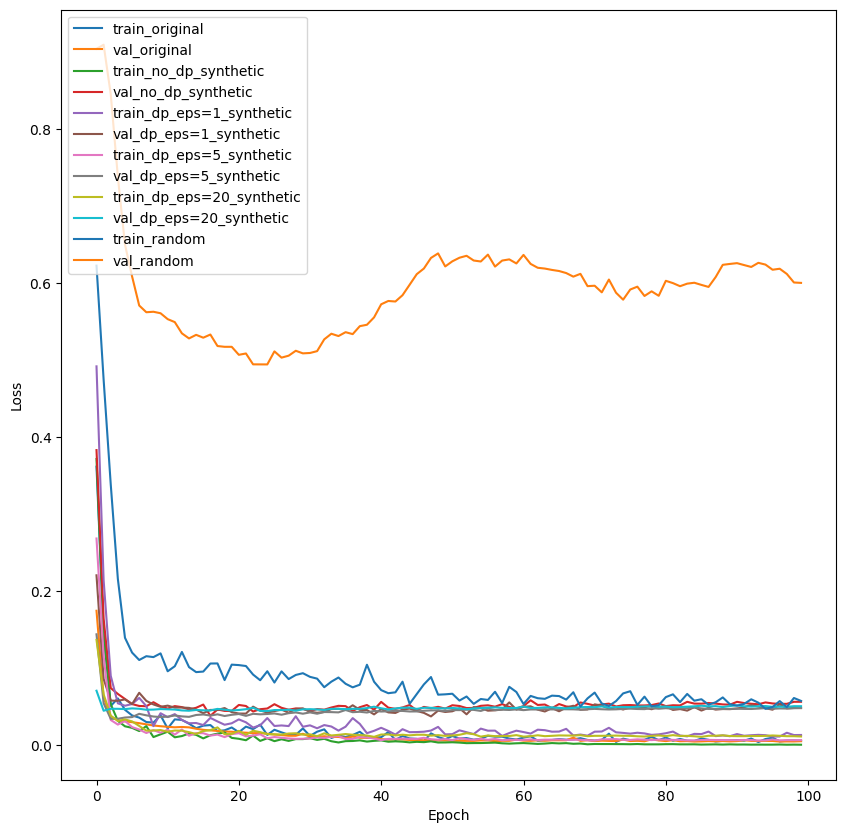

In [44]:
plt.figure(figsize=(10,10))
plt.plot(trainingEpoch_loss, label='train_original')
plt.plot(validationEpoch_loss,label='val_original')
plt.plot(trainingEpoch_no_dp_loss, label='train_no_dp_synthetic')
plt.plot(validationEpoch_no_dp_loss,label='val_no_dp_synthetic')
plt.plot(trainingEpoch_dp_loss, label='train_dp_eps=1_synthetic')
plt.plot(validationEpoch_dp_loss,label='val_dp_eps=1_synthetic')
plt.plot(trainingEpoch_dp_eps5_loss, label='train_dp_eps=5_synthetic')
plt.plot(validationEpoch_dp_eps5_loss,label='val_dp_eps=5_synthetic')
plt.plot(trainingEpoch_dp_eps20_loss, label='train_dp_eps=20_synthetic')
plt.plot(validationEpoch_dp_eps20_loss,label='val_dp_eps=20_synthetic')
plt.plot(trainingEpoch_random_loss, label='train_random')
plt.plot(validationEpoch_random_loss,label='val_random')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show